In [1]:
import json

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

import numpy as np

import openturns as ot
import openturns.viewer as viewer
import openturns.viewer as otv

import pickle

plt.rcParams['figure.dpi']= 500
plt.rcParams['text.usetex'] = True

# Importing data

In [2]:
labels = [
    r"$\alpha$",
    r"$\beta$",
    r"$\epsilon_e$",
    r"$\epsilon_c$",
    r"$d_p$",
    r"$\Gamma_{p}(0)$",
    r"$a_v$"
]

In [3]:
# Time indices in days
t = np.load('../../data/SG_time.npy')

In [4]:
# Parameters of the Steam Generator
input_dic = {}
input_dic['SG'] = json.load(open('../../data/SG_cleaning_conditioning.json'))

In [5]:
# Color scheme for chemical conditioning
colors_n = {'Morpholine': {'9.2': 'lightgreen', '9.6': 'forestgreen'},
             'ETA': {'9.6': 'slateblue'}}

In [6]:
# PCE metamodel
with open('../../data/PCE_metamodel.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    pce = unpickler.load()

# Sobol' indices

In [13]:
pce_sobol = ot.FunctionalChaosSobolIndices(pce) 

In [21]:
sobol_first_order, sobol_total = [], []
for i in range(len(labels)):
    sobol_i_f, sobol_i_t = [], []
    for j in range(75):
        sobol_i_f.append(pce_sobol.getSobolIndex(i, j))
        sobol_i_t.append(pce_sobol.getSobolTotalIndex(i, j))
    sobol_first_order.append(sobol_i_f)
    sobol_total.append(sobol_i_t)
sobol_first_order, sobol_total = np.asarray(sobol_first_order), np.asarray(sobol_total)

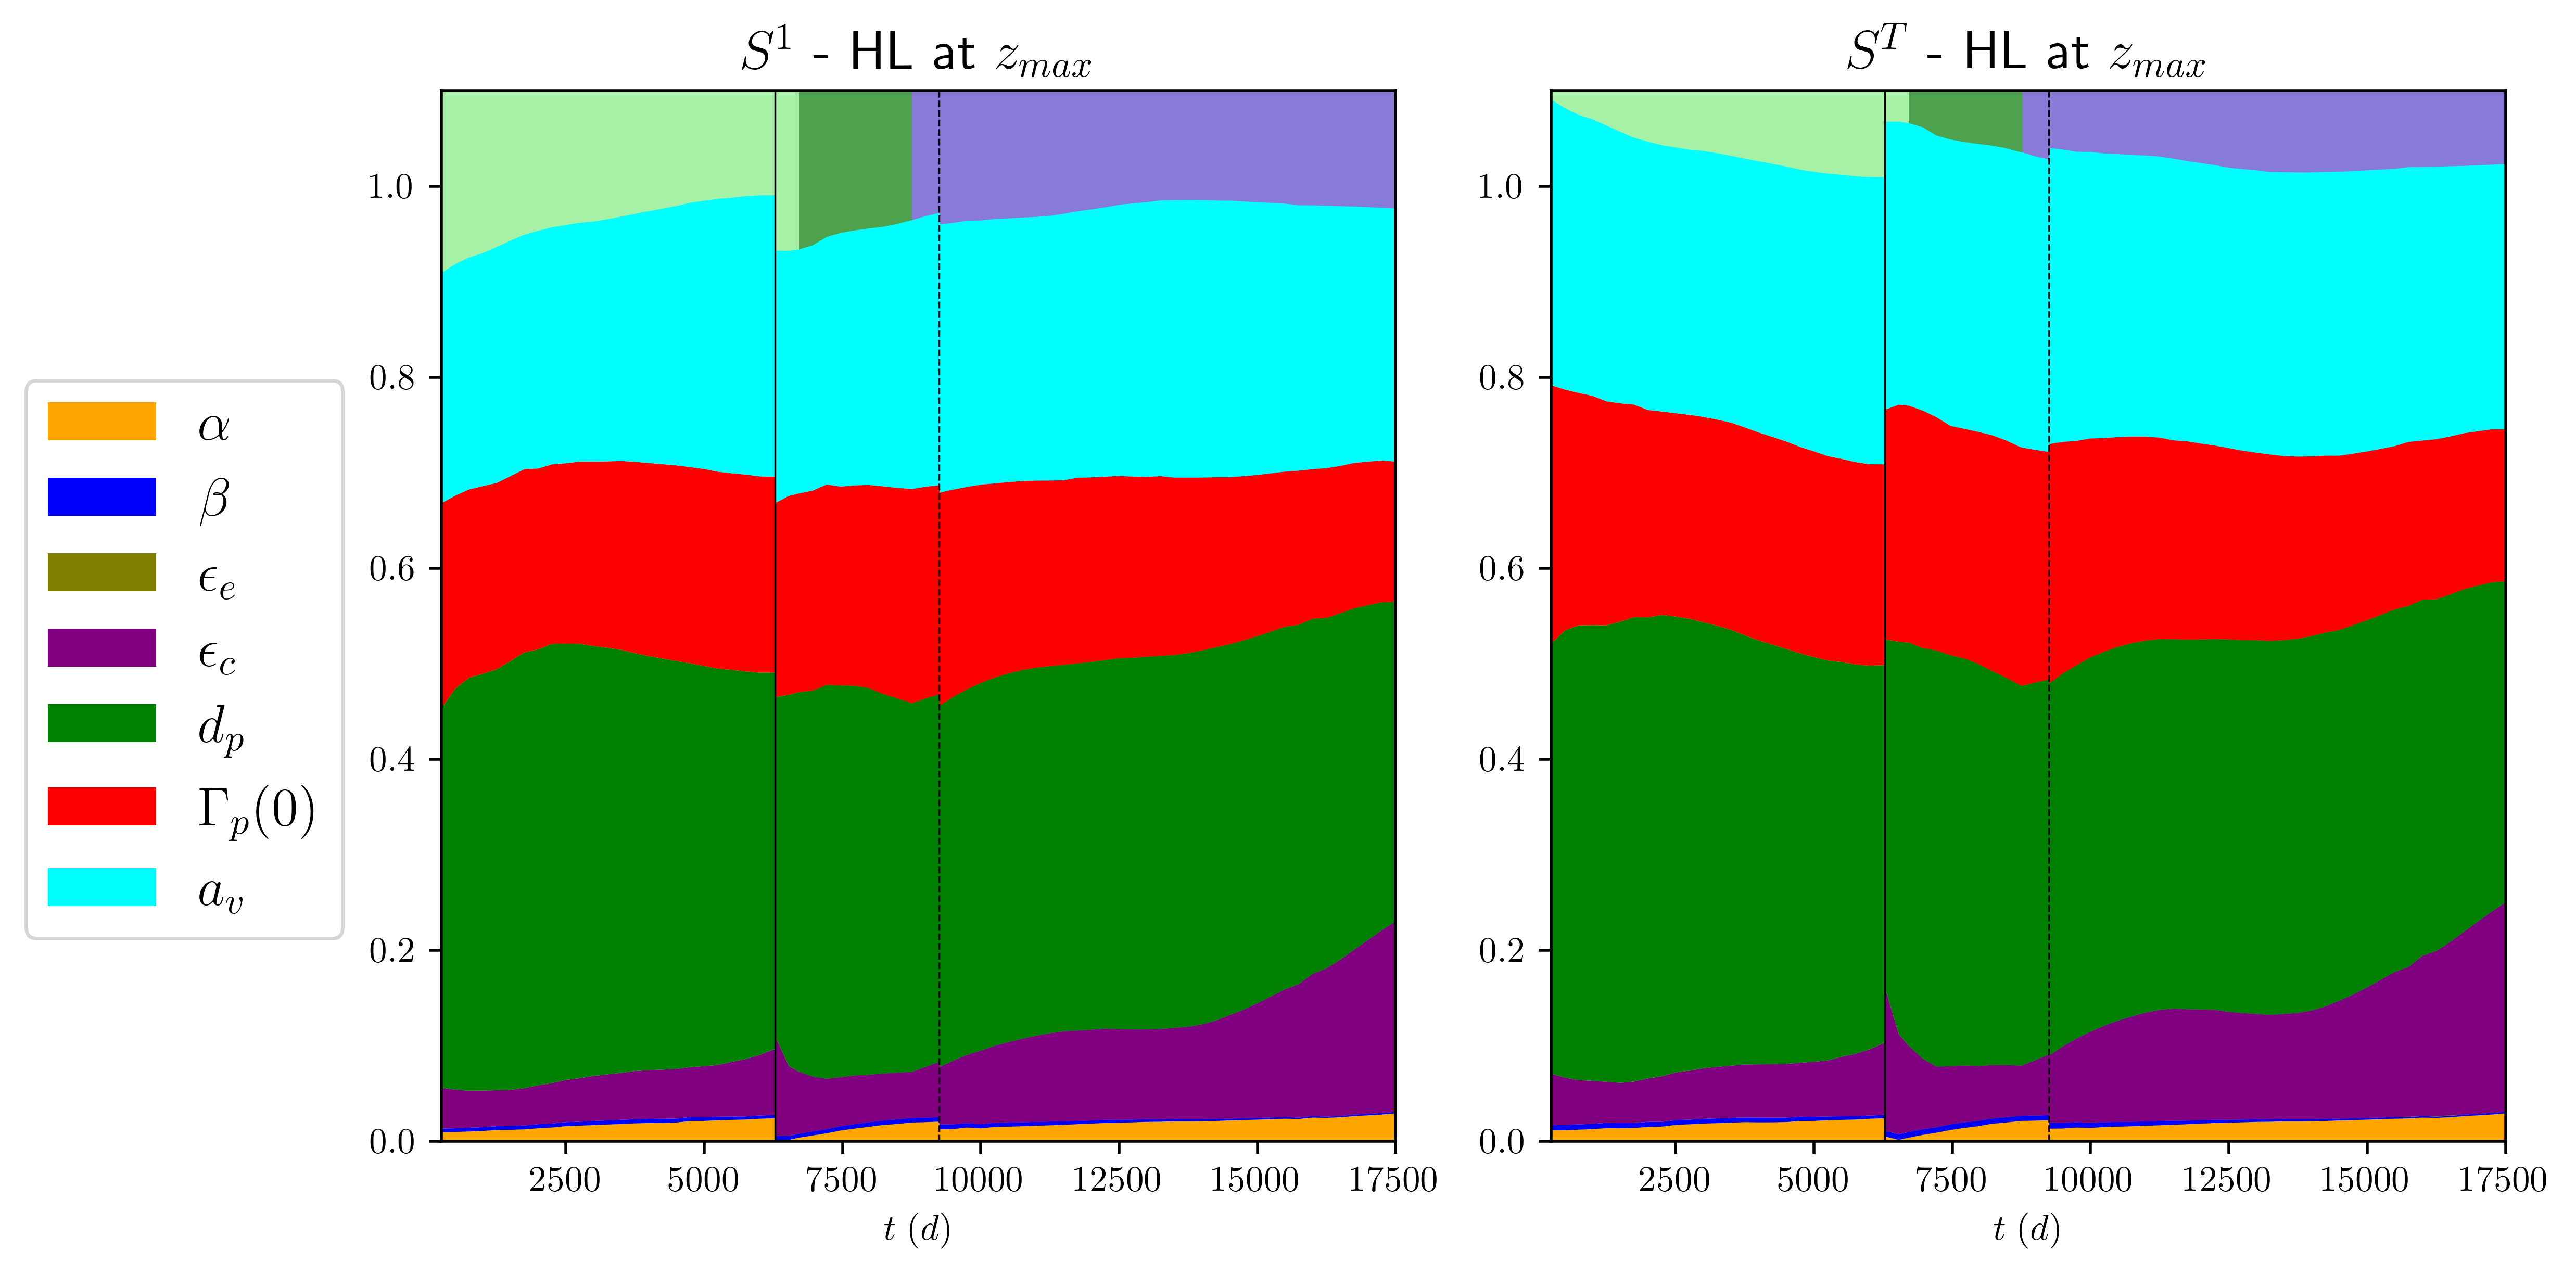

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_n[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha = 0.8)
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha = 0.8)

axs[0].stackplot(t, sobol_first_order, labels=labels, colors=colors)
axs[0].set_xlim(250,17500)
axs[0].set_ylim(0,1.1)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'$S^{1}$ - HL at $z_{max}$', fontsize=15)

axs[1].stackplot(t, sobol_total, labels=labels, colors=colors)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.1)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'$S^{T}$ - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.075,0.75), fontsize=15)

nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs[0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs[0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)


fig.savefig('../../plots/Sobol\'/PCE_S_1_T.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../../plots/Sobol\'/PCE_S_1_T.png', format='png', bbox_inches='tight')